In [1]:
run_training=True

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from imageio import imread

import seaborn as sns
sns.set_style("dark")
sns.set()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from IPython.display import HTML

import time
import copy
from tqdm import tqdm_notebook as tqdm
import cv2

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

from lime import lime_image
from skimage.segmentation import mark_boundaries

Let's see what kind of data this kernel needs:

In [3]:
listdir("../input")

['seedlingsmodel',
 'pretrained-pytorch-models',
 'seedlings',
 'v2-plant-seedlings-dataset']

In [4]:
listdir("../input/seedlingsmodel")

['running_losses_segmented_seedlings.csv',
 'segmented_seedlings_cuda.pth',
 'losses_segmented_seedlings.csv']

## Peek at the image files <a class="anchor" id="peek"></a>

In [5]:
base_path = "../input/v2-plant-seedlings-dataset/nonsegmentedv2/"
OUTPUT_PATH = "seedlings.pth"
MODEL_PATH = "../input/seedlingsmodel/seedlings.pth"

### How many images per species do we have? <a class="anchor" id="speciescount"></a>

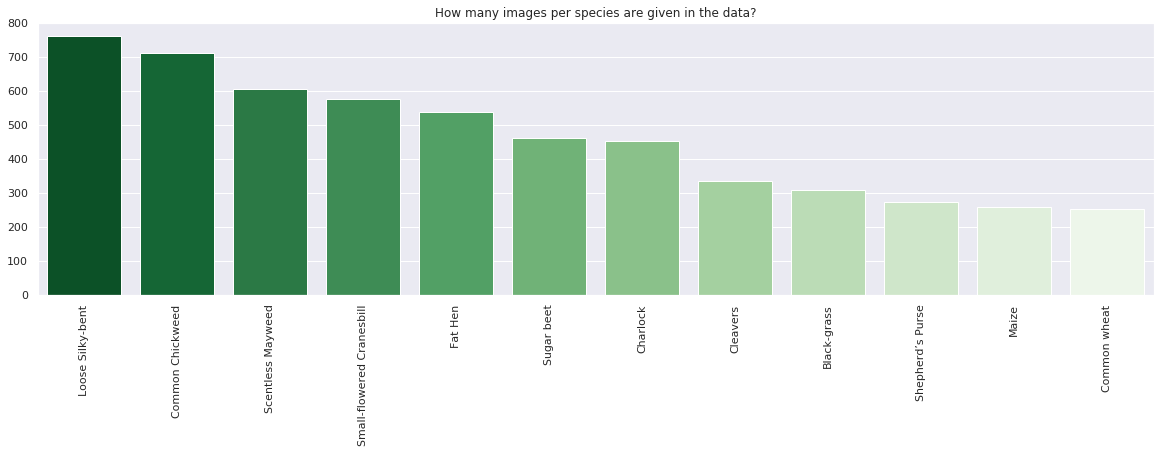

In [6]:
subfolders = listdir(base_path)
names = []
counts = []

for folder in subfolders:
    images = listdir(base_path +folder)
    names.append(folder)
    counts.append(len(images))

counts = np.array(counts)
names = np.array(names)

idx = np.argsort(counts)[::-1]
    
plt.figure(figsize=(20,5))    
sns.barplot(x=names[idx], y=counts[idx], palette="Greens_r")
plt.xticks(rotation=90);
plt.title("How many images per species are given in the data?");

### How do the species classes look like? <a class="anchor" id="examples"></a>

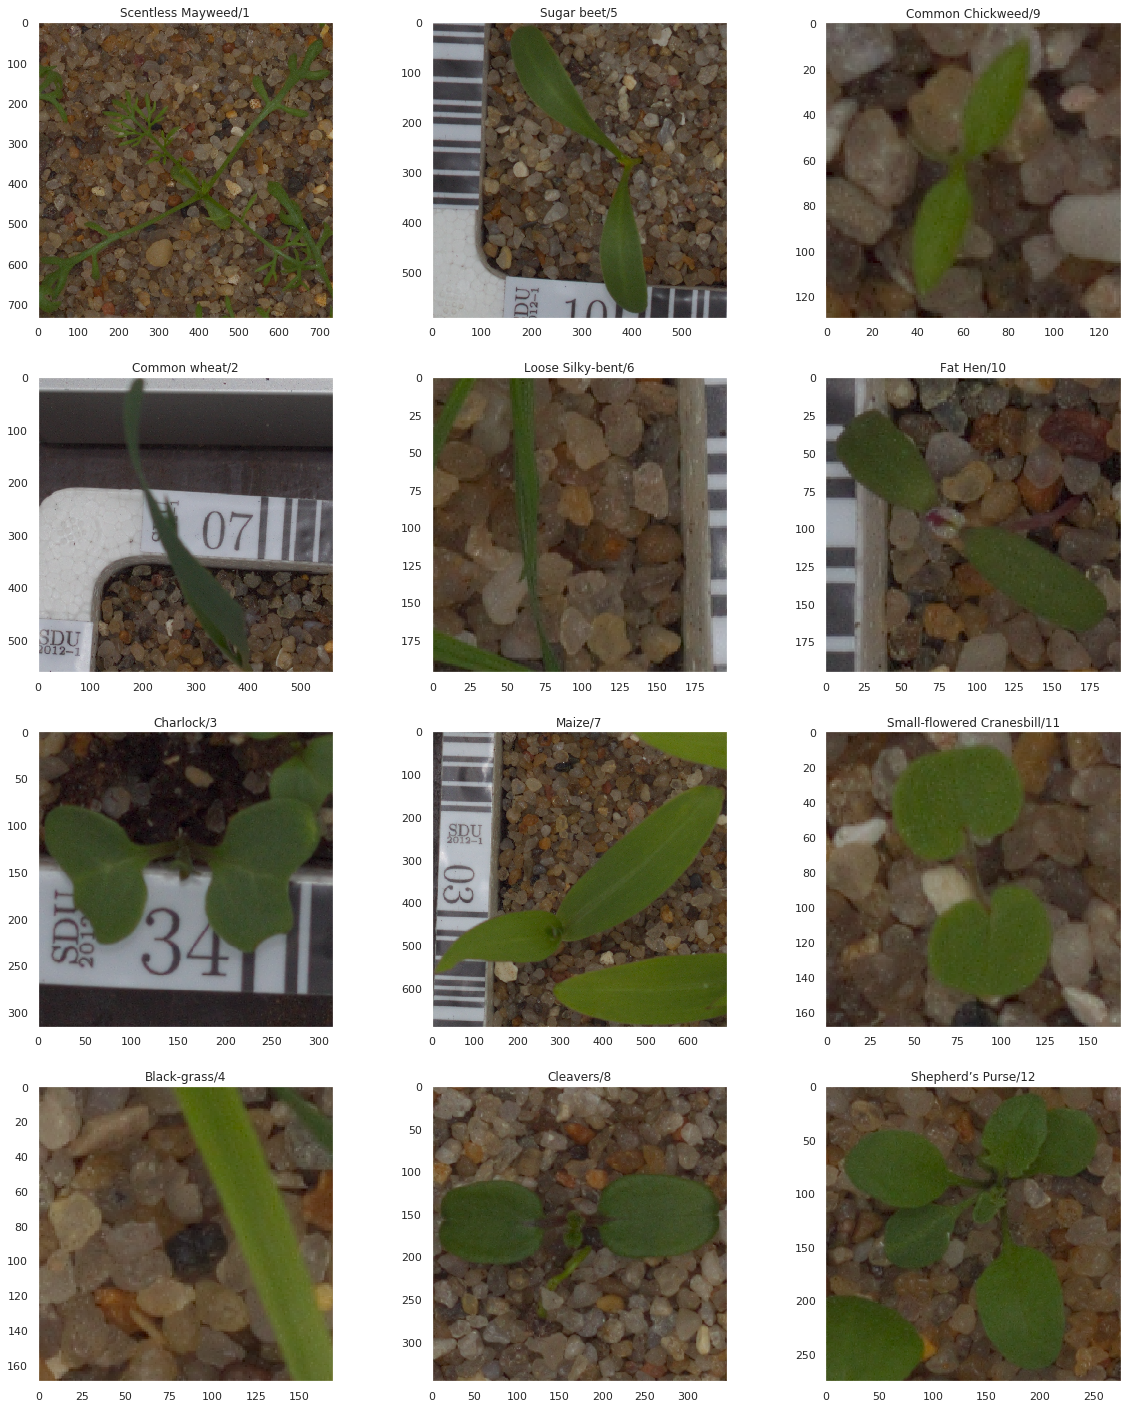

In [7]:
fig, ax = plt.subplots(4,3,figsize=(20,25))

for m in range(4):
    for n in range(3):
        folder = subfolders[m+n*4]
        files = listdir(base_path + folder + "/")
        image = imread(base_path + folder + "/" + files[0])
        ax[m,n].imshow(image)
        ax[m,n].grid(False)
        ax[m,n].set_title(folder + "/" + str(m+n*4+1))

## An unconscious target leakage <a class="anchor" id="leakage"></a>

### Can we find some order in the names of the image files? <a class="anchor" id="filenames"></a>

The image names are counters:

In [8]:
listdir(base_path + "Maize")[0:10]

['173.png',
 '248.png',
 '94.png',
 '236.png',
 '48.png',
 '227.png',
 '238.png',
 '61.png',
 '222.png',
 '37.png']

Perhaps the way images were enumerated is not random and some kind of order is hidden in the file names. It would be of great advantage if the numeration has something to do with the growth state as well:

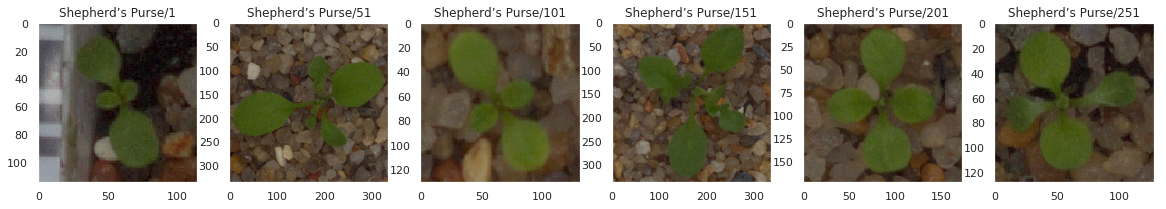

In [9]:
image_indices = np.array([0, 50, 100, 150, 200, 250])+1

fig, ax = plt.subplots(1,6,figsize=(20,5))

for n in range(6):
    idx = image_indices[n]
    image = imread(base_path + folder + "/" + str(idx) + ".png")
    ax[n].imshow(image)
    ax[n].grid(False)
    ax[n].set_title(folder + "/" + str(idx))


In [10]:
total_images = 0
for folder in subfolders:
    total_images += len(listdir(base_path + folder))

plantstate = pd.DataFrame(index=np.arange(0, total_images), columns=["width", "height", "species"])

k = 0
all_images = []
for m in range(len(subfolders)):
    folder = subfolders[m]
    
    images = listdir(base_path + folder)
    all_images.extend(images)
    n_images = len(images)
    
    for n in range(0, n_images):
        image = imread(base_path + folder + "/" + images[n])
        plantstate.loc[k, "width"] = image.shape[0]
        plantstate.loc[k, "height"] = image.shape[1]
        plantstate.loc[k, "species"] = folder
        plantstate.loc[k, "image_name"] = images[n]
        k+=1

plantstate.width = plantstate.width.astype(np.int)
plantstate.height = plantstate.height.astype(np.int)

In [11]:
plantstate.head()

width  height            species image_name
0    735     735  Scentless Mayweed    173.png
1    148     148  Scentless Mayweed    491.png
2     99      99  Scentless Mayweed    379.png
3    106     106  Scentless Mayweed    248.png
4    135     135  Scentless Mayweed     94.png

In [12]:
plantstate.shape

(5539, 4)

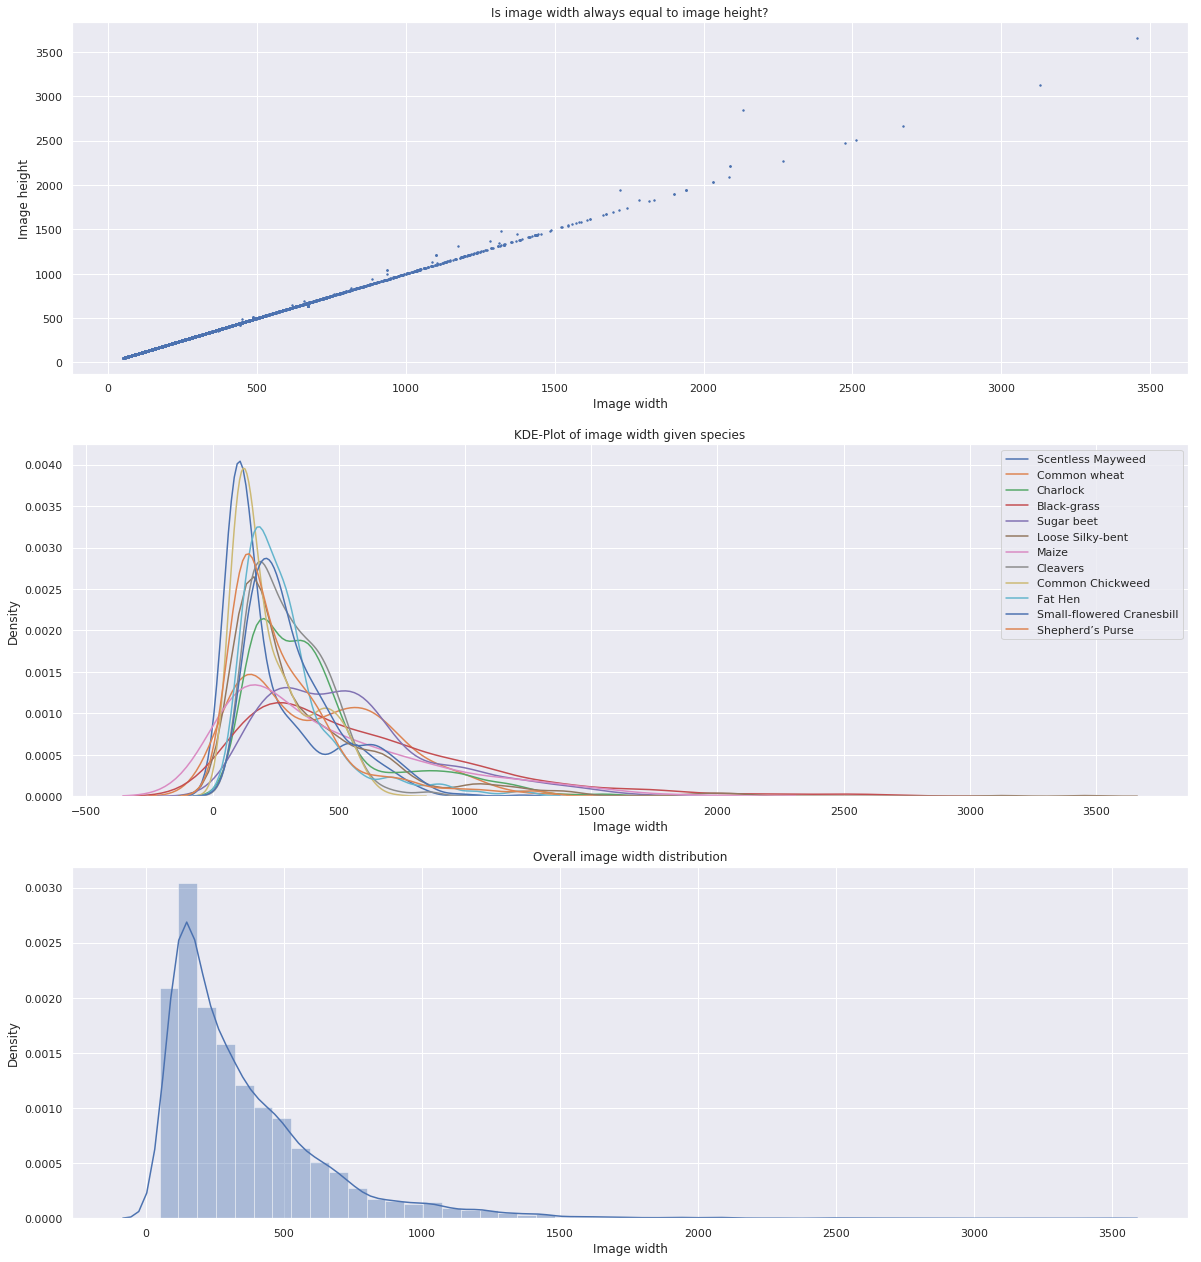

In [13]:
fig, ax = plt.subplots(3,1,figsize=(20,22))
ax[0].scatter(plantstate.width.values, plantstate.height.values, s=2)
ax[0].set_xlabel("Image width")
ax[0].set_ylabel("Image height");
ax[0].set_title("Is image width always equal to image height?")
for single in plantstate.species.unique():
    sns.kdeplot(plantstate[plantstate.species==single].width, ax=ax[1], label=single);
ax[1].legend();
ax[1].set_title("KDE-Plot of image width given species")
ax[1].set_xlabel("Image width");
ax[1].set_ylabel("Density")
sns.distplot(plantstate.width, ax=ax[2]);
ax[2].set_xlabel("Image width")
ax[2].set_ylabel("Density")
ax[2].set_title("Overall image width distribution");

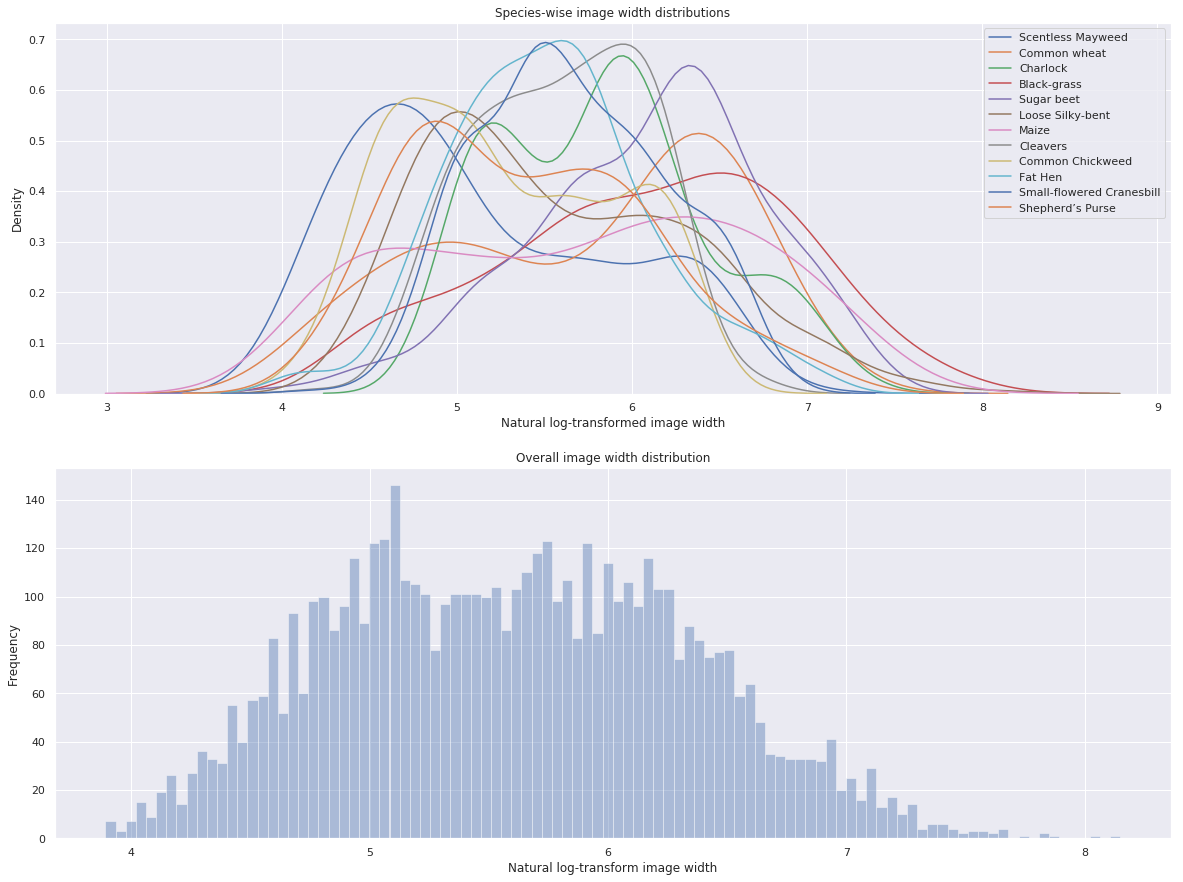

In [14]:
fig, ax = plt.subplots(2,1,figsize=(20,15))
for single in plantstate.species.unique():
    sns.kdeplot(np.log(plantstate[plantstate.species==single].width.values), label=single, ax=ax[0]);
ax[0].set_title("Species-wise image width distributions")
ax[0].set_xlabel("Natural log-transformed image width")
ax[0].set_ylabel("Density");
sns.distplot(np.log(plantstate.width.values), ax=ax[1], bins=100, kde=False);
ax[1].set_xlabel("Natural log-transform image width")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Overall image width distribution");

In [15]:
scaler = StandardScaler()

X = np.log(plantstate.width.values).reshape(-1,1)
X = scaler.fit_transform(X)

km = KMeans(n_clusters=5)
plantstate["growth_state"] = km.fit_predict(X)

In [16]:
mean_states = plantstate.groupby("growth_state").width.mean().values
state_order = np.argsort(mean_states)
mean_states

array([ 298.29688631,  168.10403397,  524.96373457, 1041.48      ,
         95.81926407])

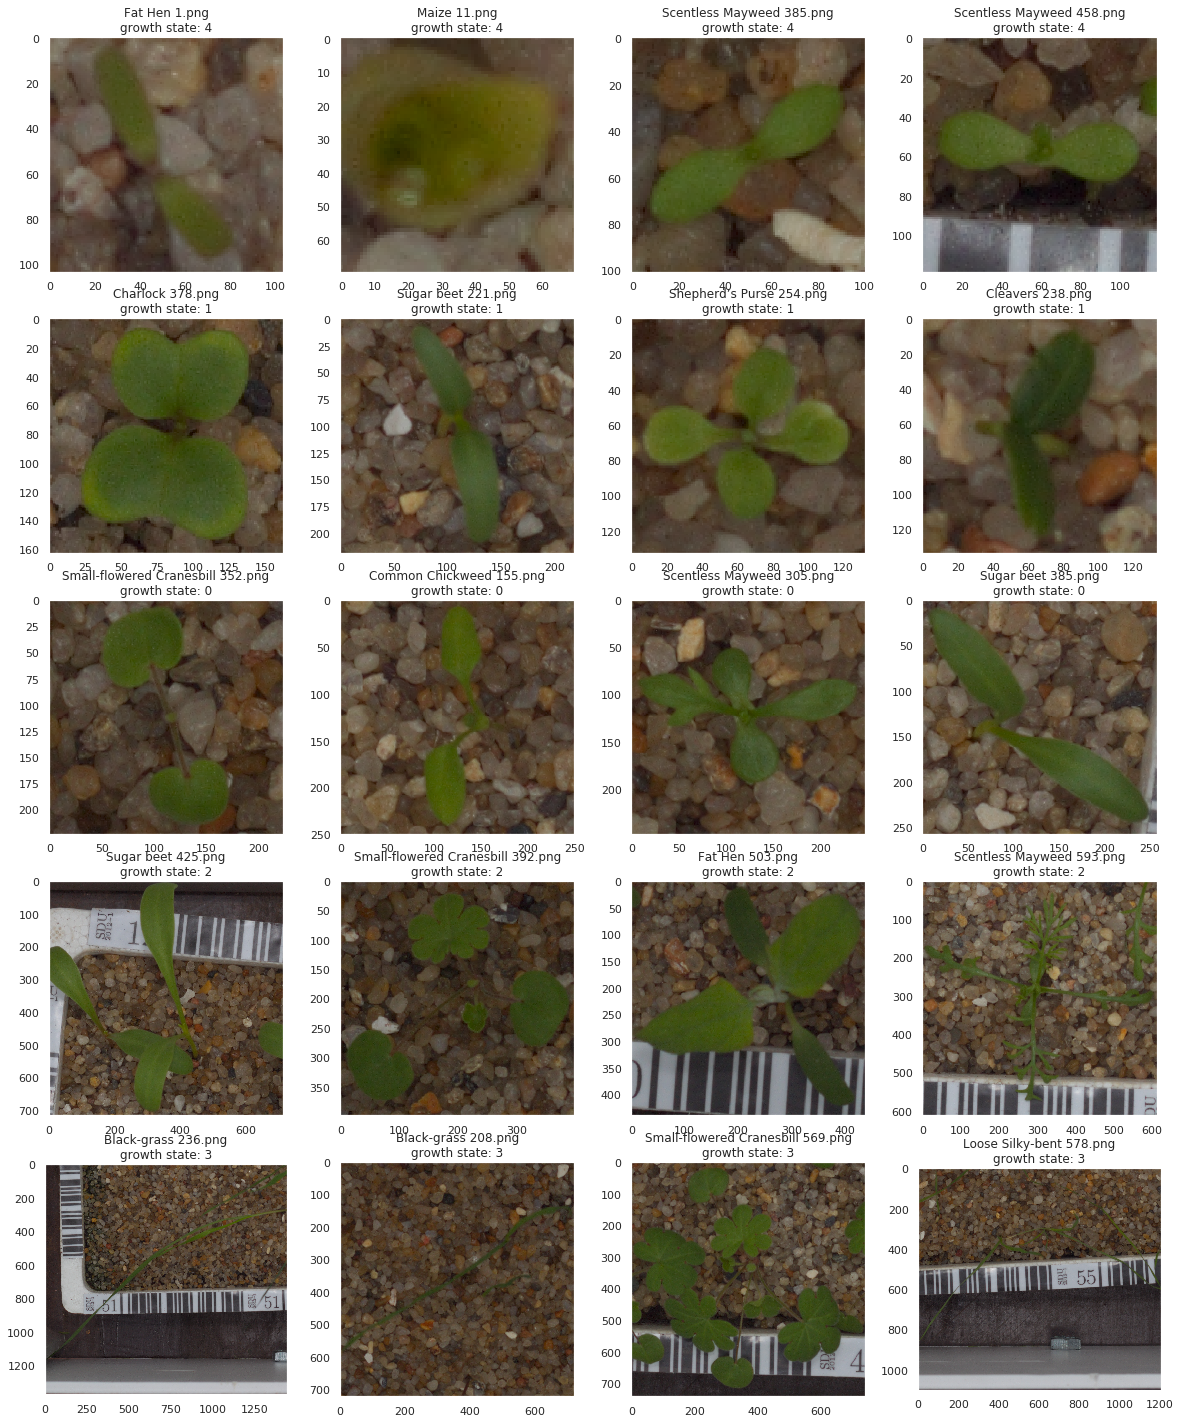

In [17]:
fig, ax = plt.subplots(len(state_order), 4, figsize=(20,5*len(state_order)))

for n in range(len(state_order)):
    your_state=state_order[n]

    example = np.random.choice(plantstate[plantstate.growth_state==your_state].index.values, size=4)
    species = plantstate.loc[example].species.values
    for m in range(4):
        image_id = all_images[example[m]]
        image = imread(base_path + species[m] + "/" + image_id)
        ax[n,m].imshow(image)
        ax[n,m].set_title(species[m] + " " + image_id + "\n" + "growth state: " + str(your_state))
        ax[n,m].grid(False);

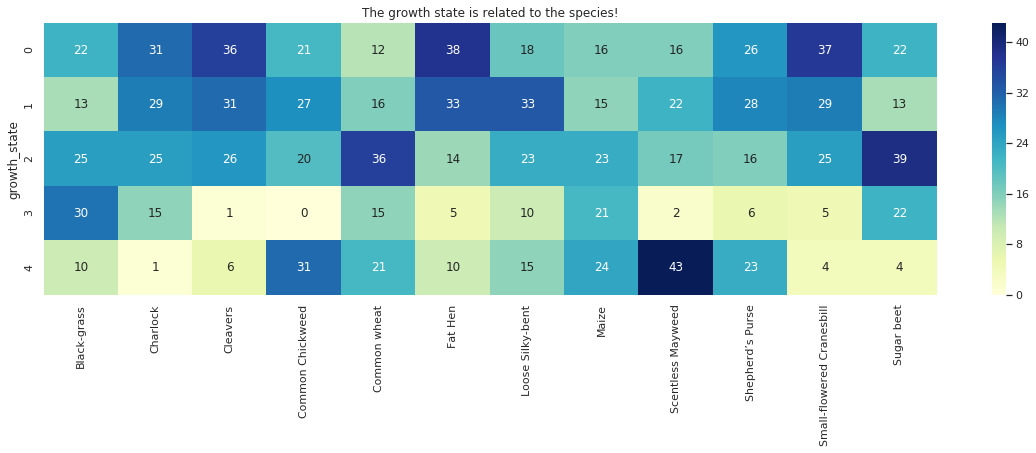

In [18]:
target_leakage = plantstate.groupby(["growth_state", "species"]).size().unstack().fillna(0) 
target_leakage = target_leakage / plantstate.species.value_counts() * 100
target_leakage = target_leakage.apply(np.round).astype(np.int)

plt.figure(figsize=(20,5))
sns.heatmap(target_leakage, cmap="YlGnBu", annot=True)
plt.title("The growth state is related to the species!");

In [19]:
encoder = LabelEncoder()
labels = encoder.fit_transform(plantstate.species.values)
plantstate["target"] = labels

NUM_CLASSES = plantstate.target.nunique()
org_plantstate = plantstate.copy()

In [20]:
def transform(key="train"):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms[key]

In [21]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class SeedlingsDataset(Dataset):
    
    def __init__(self, root_dir, df, transform=None):
        self.root_dir = root_dir
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        image_path = self.root_dir + self.states.species.values[idx] + "/" 
        image_path += self.states.image_name.values[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
         
        target = self.states.target.values[idx]
        
        
        return {"image": image, "label": target}

In [22]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(plantstate.index.values,
                                       test_size=0.3,
                                       random_state=2019,
                                       stratify=plantstate.target.values)

train_df = plantstate.loc[train_idx].copy()
val_df = plantstate.loc[test_idx].copy()

train_dataset = SeedlingsDataset(base_path, train_df, transform=transform(key="train"))
eval_dataset = SeedlingsDataset(base_path, val_df, transform=transform(key="val"))
image_datasets = {"train": train_dataset, "val": eval_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print(len(train_dataset), len(eval_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, drop_last=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False, drop_last=True)
dataloaders = {"train": train_dataloader, "val": eval_dataloader}

3877 1662


In [23]:
listdir("../input/pretrained-pytorch-models/")

['squeezenet1_0-a815701f.pth',
 'inception_v3_google-1a9a5a14.pth',
 'resnet18-5c106cde.pth',
 'squeezenet1_1-f364aa15.pth',
 'densenet161-17b70270.pth',
 'resnet50-19c8e357.pth']

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:
model = torchvision.models.resnet18(pretrained=False)
if run_training:
    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Linear(num_features, NUM_CLASSES)
model = model.to(device)

512


In [26]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())
class_weights = torch.FloatTensor(weights).cuda()

In [27]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), 1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

> 

In [28]:
def train_loop(model, criterion, optimizer, scheduler, num_epochs = 10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                
                if phase == "train":
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                
                
                running_loss += loss.item() * inputs.size(0)
                corrects = (preds == labels).sum().item()
                running_corrects += corrects
                
                
                counter += 1
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects / (counter*dataloaders[phase].batch_size)})
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [29]:
if run_training:
    model = train_loop(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
    torch.save(model.state_dict(), OUTPUT_PATH)
else:
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

Epoch 0/9
----------


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



train Loss: 1.8409 Acc: 0.3936



val Loss: 1.3851 Acc: 0.5686

Epoch 1/9
----------



train Loss: 1.2409 Acc: 0.5997



val Loss: 1.4032 Acc: 0.6378

Epoch 2/9
----------



train Loss: 1.0275 Acc: 0.6652



val Loss: 1.1776 Acc: 0.6799

Epoch 3/9
----------



train Loss: 0.9041 Acc: 0.7085



val Loss: 0.5411 Acc: 0.7184

Epoch 4/9
----------



train Loss: 0.8264 Acc: 0.7263



val Loss: 0.8825 Acc: 0.7214

Epoch 5/9
----------



train Loss: 0.7857 Acc: 0.7403



val Loss: 0.7838 Acc: 0.7497

Epoch 6/9
----------



train Loss: 0.7397 Acc: 0.7542



val Loss: 0.6594 Acc: 0.7503

Epoch 7/9
----------



train Loss: 0.6799 Acc: 0.7710



val Loss: 0.5040 Acc: 0.7473

Epoch 8/9
----------



train Loss: 0.6709 Acc: 0.7697



val Loss: 0.5825 Acc: 0.7359

Epoch 9/9
----------



train Loss: 0.6412 Acc: 0.7808



val Loss: 0.4864 Acc: 0.7738

Training complete in 11m 59s
Best val Acc: 0.773767


In [30]:
hold_out_data = org_plantstate.loc[org_plantstate.index.isin(test_idx)].copy()

In [31]:
def get_pil_transform():
    return transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(224)])

def get_preprocess_transform():
    normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])  

In [32]:
pil_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [33]:
def batch_predict(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

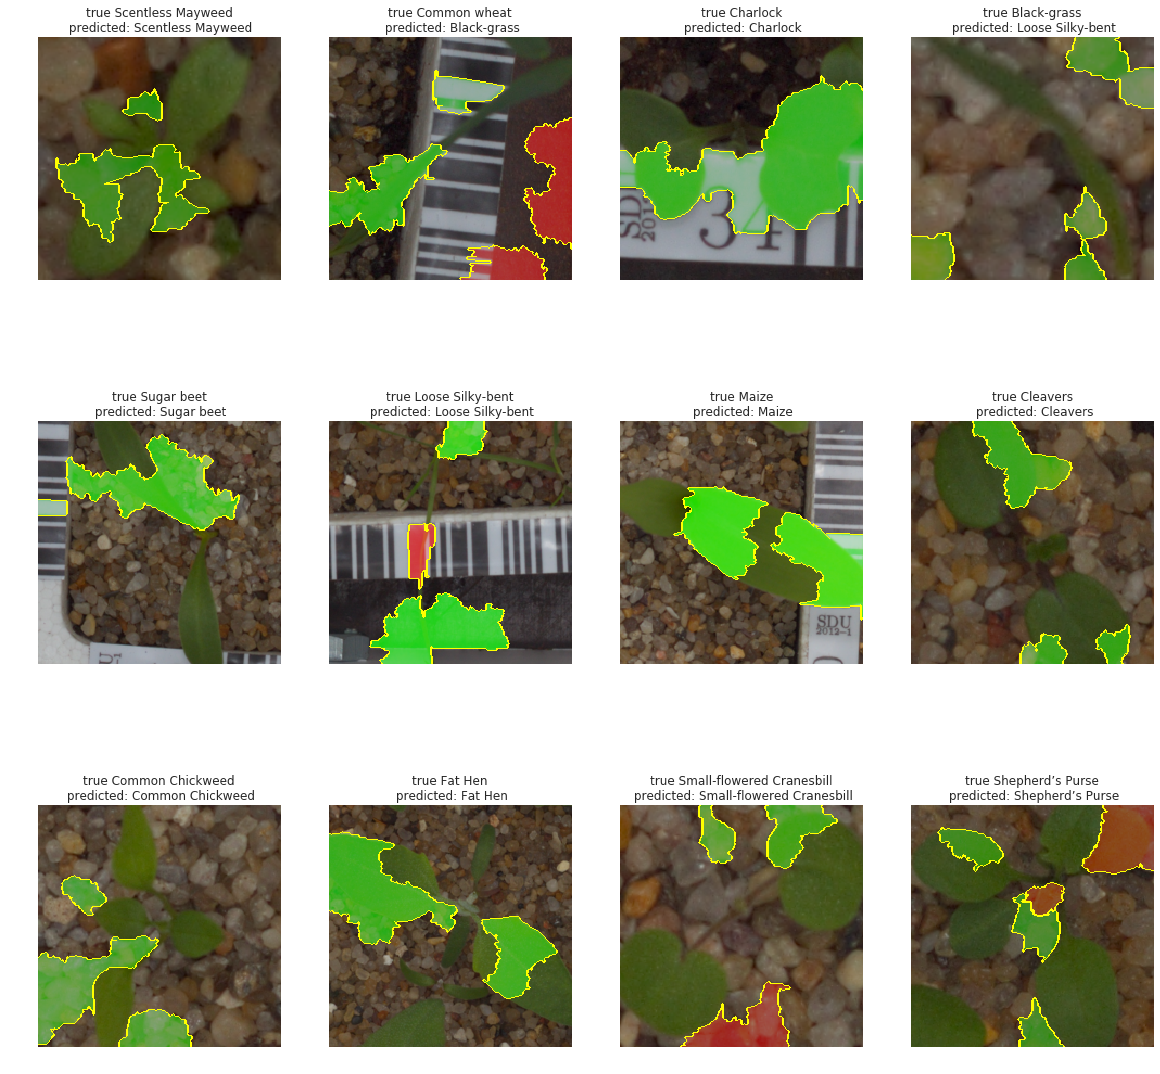

In [34]:
fig, ax = plt.subplots(3,4,figsize=(20,20))


m = 0
for i in range(3):
    for j in range(4):
        
        spec=org_plantstate.species.unique()[m]
        image_id = hold_out_data[hold_out_data.species==spec].image_name.values[0]
        image = Image.open(base_path + spec + "/" + image_id)
        image = image.convert('RGB')
        
        test_pred = batch_predict([pil_transf(image)])
        explainer = lime_image.LimeImageExplainer()

        explanation = explainer.explain_instance(np.array(pil_transf(image)), 
                                             batch_predict, # classification function
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                    positive_only=False,
                                                    num_features=5,
                                                    hide_rest=False)
        img_boundry1 = mark_boundaries(temp/255.0, mask)
        predicted_target = np.argmax(test_pred)
        predicted_species = plantstate.loc[plantstate.target==predicted_target].species.unique()[0]
        ax[i,j].imshow(img_boundry1)
        ax[i,j].axis("off")
        ax[i,j].set_title("true " + spec + "\n predicted: " + predicted_species)
        
        m+=1